In [1]:
pip install graphviz

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz
import graphviz
from datetime import timedelta
import io
import pandas as pd


In [3]:
# Tiền xử lý dữ liệu
df = pd.read_csv('C:/Users/Hp/IS403.P23_Nhom3/Dataset/amd_stock_price.csv')

df.columns = ['date', 'price', 'open', 'high', 'low', 'volume', 'change_percent']
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df['volume'] = df['volume'].replace({'M': 'e6'}, regex=True).astype(float)
df['change_percent'] = df['change_percent'].str.replace('%', '', regex=False).astype(float)
df = df.sort_values('date')

In [4]:
# Xây dựng đặc trưng
lookback = 5
X, y = [], []

for i in range(lookback, len(df)):
    X.append(df['price'].iloc[i-lookback:i].values)
    y.append(df['price'].iloc[i])

X = np.array(X)
y = np.array(y)
dates = df['date'].iloc[lookback:]

In [5]:
# Chia dữ liệu
total_len = len(X)
test_len = int(total_len * 0.2)
val_len = int(total_len * 0.1)
train_len = total_len - test_len - val_len

X_train = X[:train_len]
y_train = y[:train_len]

X_test = X[train_len:train_len + test_len]
y_test = y[train_len:train_len + test_len]

X_val = X[train_len + test_len:]
y_val = y[train_len + test_len:]

train_dates = dates[:train_len]
test_dates = dates[train_len:train_len + test_len]
val_dates = dates[train_len + test_len:]

In [6]:
# Scale dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [7]:
# Huấn luyện mô hình
model = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, max_depth=5, random_state=42)
model.fit(X_train_scaled, y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=5, n_estimators=500,
                          random_state=42)

In [8]:
# Dự đoán
y_pred_test = model.predict(X_test_scaled)
y_pred_val = model.predict(X_val_scaled)

In [9]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Hàm tính MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Đánh giá mô hình trên tập test
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print("Đánh giá mô hình trên tập test:")
print(f"RMSE: {rmse_test:.4f}")
print(f"MAE: {mae_test:.4f}")
print(f"MAPE: {mape_test:.2f}%")
print("-" * 30)

# Đánh giá mô hình trên tập validation
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
mae_val = mean_absolute_error(y_val, y_pred_val)
mape_val = mean_absolute_percentage_error(y_val, y_pred_val)

print("Đánh giá mô hình trên tập validation:")
print(f"RMSE: {rmse_val:.4f}")
print(f"MAE: {mae_val:.4f}")
print(f"MAPE: {mape_val:.2f}%")


Đánh giá mô hình trên tập test:
RMSE: 16.4983
MAE: 11.8418
MAPE: 6.82%
------------------------------
Đánh giá mô hình trên tập validation:
RMSE: 4.5212
MAE: 3.3258
MAPE: 2.98%


In [10]:
# Dự đoán tương lai
last_known = df['price'].iloc[-lookback:].values

future_preds_30 = []
future_preds_60 = []

# Dự đoán 30 ngày
current_input = last_known.copy()
for _ in range(30):
    input_scaled = scaler.transform([current_input])
    next_price = model.predict(input_scaled)[0]
    future_preds_30.append(next_price)
    current_input = np.append(current_input[1:], next_price)

# Dự đoán 60 ngày
current_input = last_known.copy()
for _ in range(60):
    input_scaled = scaler.transform([current_input])
    next_price = model.predict(input_scaled)[0]
    future_preds_60.append(next_price)
    current_input = np.append(current_input[1:], next_price)

# Future dates
last_val_date = val_dates.iloc[-1]
future_dates_30 = [last_val_date + pd.Timedelta(days=i+1) for i in range(30)]
future_dates_60 = [last_val_date + pd.Timedelta(days=i+1) for i in range(60)]

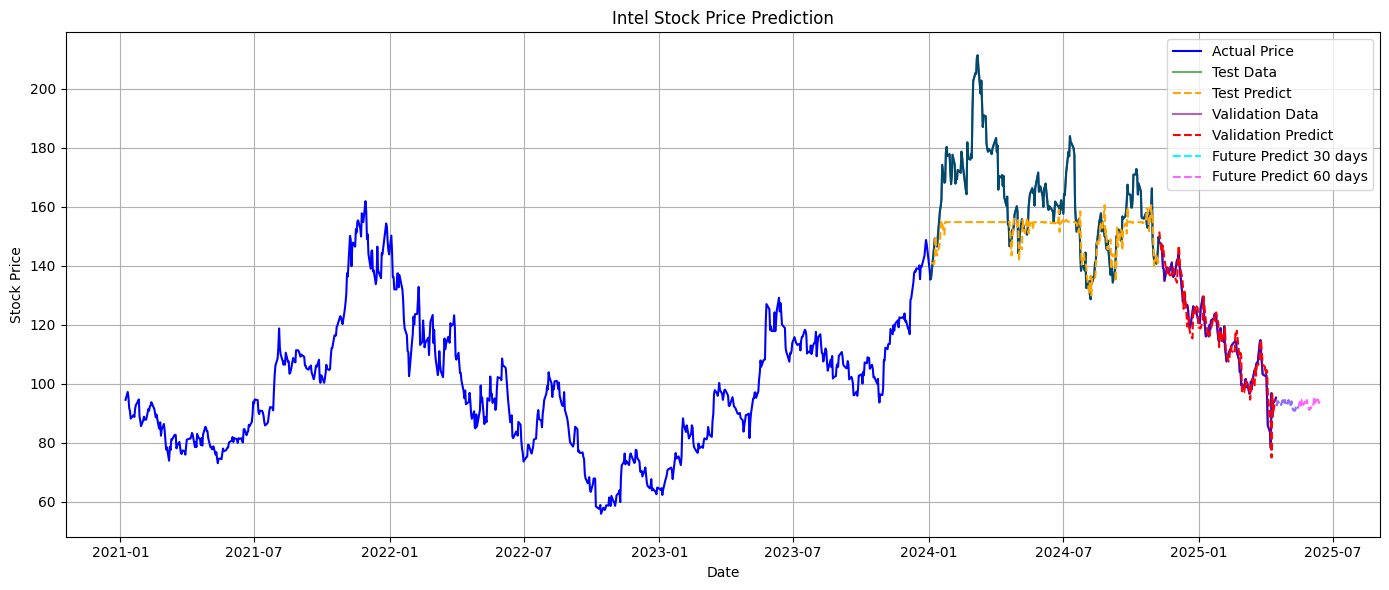

In [11]:
# Trực quan hóa
plt.figure(figsize=(14, 6))

plt.plot(dates, y, label='Actual Price', color='blue')
plt.plot(test_dates, y_test, label='Test Data', color='green', alpha=0.6)
plt.plot(test_dates, y_pred_test, label='Test Predict', linestyle='--', color='orange')
plt.plot(val_dates, y_val, label='Validation Data', color='purple', alpha=0.6)
plt.plot(val_dates, y_pred_val, label='Validation Predict', linestyle='--', color='red')
plt.plot(future_dates_30, future_preds_30, label='Future Predict 30 days', linestyle='--', color='cyan')
plt.plot(future_dates_60, future_preds_60, label='Future Predict 60 days', linestyle='--', color='magenta', alpha=0.6)

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Intel Stock Price Prediction')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()